### This model works on the hypothesis that more frequently and recently an item is purchased, higher is the probability of the customer re-purchasing it in the future. Also, higher the probability of repurchase, higher will it be in sequence in the cart.

### Please leave your comments and feedback

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
import pickle
%matplotlib inline

Database schema
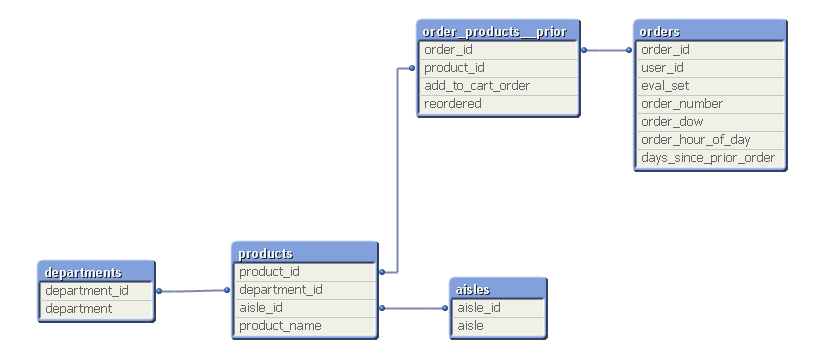

#### We won't be using ailes, departments and products dataset

In [6]:
#aisles = pd.read_csv("../input/aisles.csv")
#departments = pd.read_csv("../input/departments.csv")
orders = pd.read_csv('../input/orders.csv')
order_prior = pd.read_csv('../input/order_products__prior.csv')
order_train = pd.read_csv('../input/order_products__train.csv')
#products = pd.read_csv("../input/products.csv")

In [7]:
#print(aisles.head())
#print(departments.head())
print(orders.head())
print(order_prior.head())
print(order_train.head())
#print(products.head())

#### Orders table has all oders for all users. Column eval_set has values prior (all previous orders for users), train (single order per user for training) or test (single order for prediction without product details). We have to train the model by selecting users with prior and training orders and then predict for users that have prior and testing orders. Let us create separate tables for training and prediction purpose. 

In [8]:
users_train = orders.user_id[orders.eval_set=='train']
data_train = orders[orders['user_id'].isin(users_train)]
data_train.head()

In [9]:
users_predict = orders.user_id[orders.eval_set=='test']
data_predict = orders[orders['user_id'].isin(users_predict)]
data_predict.head()

#### To better train the model, select users with higher number of prioir orders created. We are taking median as threshold

In [10]:
data_train.groupby('user_id').order_number.max().median() 

#### Let us take users that have 10 or more prior orders in the tranining set 

In [11]:
users_10 = data_train.user_id[data_train.order_number > 9]
data_train = data_train[data_train['user_id'].isin(users_10)]
data_train.info()

#### We will take a single user in the training data set and split it's orders into training and testing using eval_set to check. We are using user id 2 below. 

In [12]:
orders_train = data_train.loc[(data_train.user_id==2) & (data_train.eval_set=='prior'),:]
orders_train = pd.merge(orders_train,order_prior,'inner',on='order_id')
orders_test = data_train.loc[(data_train.user_id==2) & (data_train.eval_set=='train'),:]
orders_test = pd.merge(orders_test,order_train,'inner',on='order_id')
print(orders_train.head())
print(orders_test.head())

#### For the single user above, create a table with order number, days since last order and cumulative number of days from from first order

In [13]:
order_days = orders_train[['order_number','days_since_prior_order']]
order_days = order_days.drop_duplicates()
order_days.update(order_days[['days_since_prior_order']].fillna(0))
order_days['cum_days'] = order_days['days_since_prior_order'].cumsum()
order_days

#### Add the new column for cumulative days to the training dataset

In [14]:
order_map = order_days.groupby('order_number').cum_days.mean().to_dict()
orders_train['cum_days'] = orders_train.order_number.map(order_map)
orders_train.head()

#### Calculate recency for each product by first finding out the last time it was ordered and then subracting it from the latest order days. So if a product belonged in the latest order, it's recency will be zero. Convert recency days into recency weeks

In [15]:
recency_map = orders_train.groupby('product_id').cum_days.max().to_dict()
orders_train['recency'] = (orders_train.cum_days.max() - orders_train.product_id.map(recency_map)) / 7
orders_train.head()

#### Calculate frequencies of all products and then normalize by dividing frquency by total number of orders for the user

In [16]:
frequency_map = orders_train['product_id'].value_counts().to_dict()
orders_train['frequency'] = orders_train.product_id.map(frequency_map) / orders_train.order_number.max()
orders_train.head()

#### Find average cart order for each product and normalize by dividing by average number of products in the cart

In [17]:
cart_order_map = orders_train.groupby('product_id').add_to_cart_order.mean().to_dict()
orders_train['cart_order'] = orders_train.product_id.map(cart_order_map) / \
                             orders_train.groupby('order_number').order_number.value_counts().mean()
orders_train.head()    

#### Create intermediate table that will be used to create final rfm table 

In [18]:
orders_train = orders_train[['product_id','recency','frequency','cart_order']].copy()
orders_train = orders_train.drop_duplicates()
orders_train.head()

#### Create final rfm table by merging it with testing table which will give us buy or no buy for each product.

In [19]:
orders_test['buy'] = 1
orders_test = orders_test[['product_id','buy']]
df = pd.merge(orders_train,orders_test,'left',on='product_id')
df.update(df[['buy']].fillna(0))
df = df.drop(['product_id'], axis = 1)
df.head()

#### Now that we have seen how to create the table for analysis let us create a function to create the rfm table as above for user ids passed as list

In [20]:
def prepare_rfm(user_ids):
    frames = []
    for user_id in user_ids:
        orders_train = data_train.loc[(data_train.user_id==user_id) & (data_train.eval_set=='prior'),:]
        orders_train = pd.merge(orders_train,order_prior,'inner',on='order_id')
        orders_test = data_train.loc[(data_train.user_id==user_id) & (data_train.eval_set=='train'),:]
        orders_test = pd.merge(orders_test,order_train,'inner',on='order_id')
        frequency_map = orders_train['product_id'].value_counts().to_dict()
        order_days = orders_train[['order_number','days_since_prior_order']]
        order_days = order_days.drop_duplicates()
        order_days.update(order_days[['days_since_prior_order']].fillna(0))
        order_days['cum_days'] = order_days['days_since_prior_order'].cumsum()
        order_map = order_days.groupby('order_number').cum_days.mean().to_dict()
        orders_train['cum_days'] = orders_train.order_number.map(order_map)
        recency_map = orders_train.groupby('product_id').cum_days.max().to_dict()
        orders_train['recency'] = (orders_train.cum_days.max() - orders_train.product_id.map(recency_map)) / 7
        orders_train['frequency'] = orders_train.product_id.map(frequency_map) / orders_train.order_number.max()
        cart_order_map = orders_train.groupby('product_id').add_to_cart_order.mean().to_dict()
        orders_train['cart_order'] = orders_train.product_id.map(cart_order_map) / \
                                     orders_train.groupby('order_number').order_number.value_counts().mean()
        orders_train = orders_train[['product_id','recency','frequency','cart_order']].copy()
        orders_train = orders_train.drop_duplicates()
        orders_test['buy'] = 1
        orders_test = orders_test[['product_id','buy']]
        orders_comb = pd.merge(orders_train,orders_test,'left',on='product_id')
        orders_comb.update(orders_comb[['buy']].fillna(0))
        orders_comb = orders_comb.drop(['product_id'], axis = 1)
        frames.append(orders_comb)
    df = pd.concat(frames)    
    return df

#### We will just select some random 200 users and create an rfm style table. We can select more and actually I had trained the model earlier using 1000 users but it takes more time.

In [27]:
users_train = data_train['user_id'].unique()
user_ids = list(np.random.choice(users_train, 200))
df = prepare_rfm(user_ids)
df.buy.value_counts()

#### Following code can be used to save the data frame as created above and then retrieve it at a later point

In [22]:
#with open('df.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
#    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)

#with open('df.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
#    df = pickle.load(f)

#### Build the final model to make the predictions on the test set. We will use logistic regression model as this will give us the probabilities for buying a product. Since the dataset is biased on class, we will use class weight parameter to force it to predict the rare class. Using class weight of 0.12 for class 0 give accuracy of 84% and ROC area 0.75 which is a fair model.

In [28]:
features = ['recency','frequency','cart_order']
X = df[features].copy()
y = df['buy'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
logreg = LogisticRegression(class_weight={0:0.12})
logreg.fit(X_train, y_train)
predictions = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)
print(accuracy_score(y_true = y_test, y_pred = predictions))
print(roc_auc_score(y_test,predictions))

#### Using the logic in prepare rfm function above with some enhancements, following code will take the prediction users data and return a list of predicted products. The predict_proba function will return the probability of buying each product for each customer in their prior orders. 

#### I have used a threshold of 0.5 for buy and ordered the products by descending probability value to get the cart order. One can reduce the threshold to a lower value say up to 0.25 because it is better to recommend more products than not to. We will just use 10 users in the prediction table to make the predictions.

In [30]:
orders_test = data_predict.loc[data_predict.eval_set=='test',:]
orders_test = orders_test.iloc[:10,]
features = ['recency','frequency','cart_order']
submission = []
for index, row in orders_test.iterrows():
    orders_predict = data_predict.loc[(data_predict.user_id==row.user_id) & (data_predict.eval_set=='prior'),:]
    orders_predict = pd.merge(orders_predict,order_prior,'inner',on='order_id')
    frequency_map = orders_predict['product_id'].value_counts().to_dict()
    order_days = orders_predict[['order_number','days_since_prior_order']]
    order_days = order_days.drop_duplicates()
    order_days.update(order_days[['days_since_prior_order']].fillna(0))
    order_days['cum_days'] = order_days['days_since_prior_order'].cumsum()
    order_map = order_days.groupby('order_number').cum_days.mean().to_dict()
    orders_predict['cum_days'] = orders_predict.order_number.map(order_map)
    recency_map = orders_predict.groupby('product_id').cum_days.max().to_dict()
    orders_predict['recency'] = (orders_predict.cum_days.max() - orders_predict.product_id.map(recency_map)) / 7
    orders_predict['frequency'] = orders_predict.product_id.map(frequency_map) / orders_predict.order_number.max()
    cart_order_map = orders_predict.groupby('product_id').add_to_cart_order.mean().to_dict()
    orders_predict['cart_order'] = orders_predict.product_id.map(cart_order_map) / \
                               orders_predict.groupby('order_number').order_number.value_counts().mean()
    orders_predict = orders_predict[['product_id','recency','frequency','cart_order']].copy()
    orders_predict = orders_predict.drop_duplicates()
    df_predict = orders_predict.copy()
    X = df_predict[features].copy()
    y_proba = logreg.predict_proba(X)
    df_pred = pd.DataFrame({"product_id":df_predict['product_id'],"probability":y_proba[:,1]})
    df_pred = df_pred[df_pred.probability >= 0.5]
    df_pred = df_pred.sort_values(["probability"], ascending = False)
    ord_text = str(row['order_id'])
    prods_text = " ".join(str(x) for x in df_pred['product_id'].values)
    submit_text = ord_text + ", " + prods_text
    submission.append([submit_text])   

#### Let us check the first 10 predictions

In [32]:
print(submission)